In [1]:
import os, sys, time, traceback
import pycuda.driver as cuda
from copy import deepcopy
import pycuda.autoinit
import tensorrt as trt
import cv2
import numpy as np

class NMS(object):

    @staticmethod
    def get_iou(bb1, bb2):
        """
        Calculate the Intersection over Union (IoU) of two bounding boxes.

        Parameters
        ----------
        bb1 : dict
            Keys: {'x1', 'x2', 'y1', 'y2'}
            The (x1, y1) position is at the top left corner,
            the (x2, y2) position is at the bottom right corner
        bb2 : dict
            Keys: {'x1', 'x2', 'y1', 'y2'}
            The (x, y) position is at the top left corner,
            the (x2, y2) position is at the bottom right corner

        Returns
        -------
        float
            in [0, 1]
        """
        left1,top1,right1,bottom1 = bb1
        left2,top2,right2,bottom2 = bb2

        # determine the coordinates of the intersection rectangle
        x_left = max(left1, left2)
        y_top = max(top1, top2)
        x_right = min(right1, right2)
        y_bottom = min(bottom1, bottom2)

        if x_right < x_left or y_bottom < y_top:
            return 0.0

        # The intersection of two axis-aligned bounding boxes is always an
        # axis-aligned bounding box
        intersection_area = (x_right - x_left) * (y_bottom - y_top)

        # compute the area of both AABBs
        bb1_area = (right1 - left1) * (bottom1 - top1)
        bb2_area = (right2 - right1) * (bottom2 - top2)

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = 0.0
        if(bb1_area + bb2_area - intersection_area) == 0.0:
            iou = 1.0
        else:
            iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

        return iou

    @staticmethod
    def filter(rects):
        results = []
        rids = []

        for rid,rect in enumerate(rects):
            rids.append(rid)

        del_rids = []
        scores = []  #  仅仅为了debug使用
        for i_rid in rids:
            for j_rid in rids:
                if j_rid <= i_rid:
                    continue

                bbx_i = rects[i_rid]
                bbx_j = rects[j_rid]

                iou = NMS.get_iou(bbx_i, bbx_j)

                score = i_rid,j_rid,iou
                if iou >= 0.9:
                    del_rids.append(j_rid)
                scores.append(score)

        for rid,rect in enumerate(rects):
            if int(rid) not in del_rids:
                results.append(rect)

        return results


class PeopleNetPostProcess(object):

    def __init__(self, width, height, score=0.6, classes=[0]):
        '''
        Params:
            width,height(int) is the image-size that you want to get the BBX
            score(float) is the confidence
            classes(int-list) is the 3-classes(0 for person,1 for bag, 2 for face)
        '''
        self.image_width = width
        self.image_height = height

        self.model_h = 544
        self.model_w = 960
        self.stride = 16.0
        self.box_norm = 35.0

        self.grid_h = int(self.model_h / self.stride)
        self.grid_w = int(self.model_w / self.stride)
        self.grid_size = self.grid_h * self.grid_w

        self.grid_centers_w = []
        self.grid_centers_h = []

        for i in range(self.grid_h):
            value = (i * self.stride + 0.5) / self.box_norm
            self.grid_centers_h.append(value)

        for i in range(self.grid_w):
            value = (i * self.stride + 0.5) / self.box_norm
            self.grid_centers_w.append(value)

        '''
        min_confidence (float): min confidence to accept detection
        analysis_classes (list of int): indices of the classes to consider
        '''
        self.min_confidence = score
        self.analysis_classes = classes

    def applyBoxNorm(self, o1, o2, o3, o4, x, y):
        """
        Applies the GridNet box normalization
        Args:
            o1 (float): first argument of the result
            o2 (float): second argument of the result
            o3 (float): third argument of the result
            o4 (float): fourth argument of the result
            x: row index on the grid
            y: column index on the grid

        Returns:
            float: rescaled first argument
            float: rescaled second argument
            float: rescaled third argument
            float: rescaled fourth argument
        """
        o1 = (o1 - self.grid_centers_w[x]) * -self.box_norm
        o2 = (o2 - self.grid_centers_h[y]) * -self.box_norm
        o3 = (o3 + self.grid_centers_w[x]) * self.box_norm
        o4 = (o4 + self.grid_centers_h[y]) * self.box_norm
        return o1, o2, o3, o4

    def change_model_size_to_real(self, model_size, type):
        real_size = 0
        if type == 'x':
            real_size = (model_size / float(self.model_w)) * self.image_width
        elif type == 'y':
            real_size = (model_size / float(self.model_h)) * self.image_height
        real_size = int(real_size)
        return real_size

    def start(self, buffer_bbox, buffer_scores):
        """
        Postprocesses the inference output
        Args:
            outputs (list of float): inference output
        Returns: list of list tuple: each element is a two list tuple (x, y) representing the corners of a bb
        """

        bbs = []
        for c in range(3):
            if c not in self.analysis_classes:
                continue

            x1_idx = (c * 4 * self.grid_size)
            y1_idx = x1_idx + self.grid_size
            x2_idx = y1_idx + self.grid_size
            y2_idx = x2_idx + self.grid_size

            boxes = buffer_bbox
            for h in range(self.grid_h):
                for w in range(self.grid_w):
                    i = w + h * self.grid_w
                    score = buffer_scores[c * self.grid_size + i]
                    if score >= self.min_confidence:
                        o1 = boxes[x1_idx + w + h * self.grid_w]
                        o2 = boxes[y1_idx + w + h * self.grid_w]
                        o3 = boxes[x2_idx + w + h * self.grid_w]
                        o4 = boxes[y2_idx + w + h * self.grid_w]

                        o1, o2, o3, o4 = self.applyBoxNorm(o1, o2, o3, o4, w, h)

                        xmin_model = int(o1)
                        ymin_model = int(o2)
                        xmax_model = int(o3)
                        ymax_model = int(o4)

                        xmin_image = self.change_model_size_to_real(xmin_model, 'x')
                        ymin_image = self.change_model_size_to_real(ymin_model, 'y')
                        xmax_image = self.change_model_size_to_real(xmax_model, 'x')
                        ymax_image = self.change_model_size_to_real(ymax_model, 'y')

                        rect = (xmin_image, ymin_image, xmax_image, ymax_image)

                        bbs.append(rect)
        return bbs


class PeopleNetTRTInference(object):

    def __init__(self, width, height, model_path='models/resnet34_peoplenet_fp16.engine',warm_up=True):
        self.dtype = trt.float32
        self.width = 960
        self.height = 544
        self.channel = 3

        logger = trt.Logger()
        runtime = trt.Runtime(logger)
        with open(model_path, 'rb') as file:
            engine = runtime.deserialize_cuda_engine(file.read())

        self.context = engine.create_execution_context()

        self.host_input = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)),
                                                dtype=trt.nptype(self.dtype))

        #  BBox
        self.host_output_0 = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(1)),
                                                   dtype=trt.nptype(self.dtype))
        #  Confidence
        self.host_output_1 = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(2)),
                                                   dtype=trt.nptype(self.dtype))

        self.device_input = cuda.mem_alloc(self.host_input.nbytes)
        self.device_output_0 = cuda.mem_alloc(self.host_output_0.nbytes)
        self.device_output_1 = cuda.mem_alloc(self.host_output_1.nbytes)

        self.stream = cuda.Stream()

        self.post_process = PeopleNetPostProcess(width, height)

        if warm_up:
            self.warm_up()

    def start(self, raw):
        image = deepcopy(raw)
        image = cv2.resize(image, (self.width, self.height))

        img_array = np.asarray(image).astype(trt.nptype(self.dtype))  # .ravel()
        img_array = img_array.transpose(2, 0, 1) / 255.0
        img_array = img_array.ravel()
        np.copyto(self.host_input, img_array)

        #
        # Transfer input data to the GPU.
        #
        cuda.memcpy_htod_async(self.device_input, self.host_input, self.stream)

        ret = self.context.execute_async(batch_size=1, bindings=[int(self.device_input), int(self.device_output_0),
                                                                 int(self.device_output_1)],
                                         stream_handle=self.stream.handle)

        # Transfer predictions back from the GPU.
        cuda.memcpy_dtoh_async(self.host_output_0, self.device_output_0, self.stream)
        cuda.memcpy_dtoh_async(self.host_output_1, self.device_output_1, self.stream)

        self.stream.synchronize()

        rects = self.post_process.start(self.host_output_0, self.host_output_1)
        rects = NMS.filter(rects)
        return rects

    def warm_up(self):

        print('Start Warm-up.')
        for i in range(10):
            image = np.random.randint(0, 255, size=(300, 300, 3), dtype=np.uint8)
            self.start(image)
        print('Stop Warm-up.')

In [2]:
if __name__ == '__main__':

    pp = PeopleNetTRTInference(960, 544, 'models/resnet34_peoplenet_fp16.engine')

    image = cv2.imread('output_images/output_544_960.jpg')
    rects = pp.start(image)

    for rect in rects:
        left, top, right, bottom = rect
        cv2.rectangle(image, (left, top), (right, bottom), (0, 0, 255), 2)

    cv2.imwrite('images/output.jpg', image)


Start Warm-up.
Stop Warm-up.


In [3]:
import re
pp = PeopleNetTRTInference(960, 544, 'models/resnet34_peoplenet_fp16.engine')
directory = 'output_images'
fw = open("inference_images/logs.txt", "w")
ground_truth = 26
smallest_rect = 10000

height_array = []
width_array = []
count_array = []
smallest_rects_in_group = []

fw.writelines(f'Ground Truth: {ground_truth}\n')
for filename in os.listdir(directory):
    path = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(path):
        fw.writelines(f'-----------------Processing {filename}-------------------------\n')
        res = os.path.splitext(filename)[0].split('_')
        height, width = res[1], res[2]
        image = cv2.imread(path)
        rects = pp.start(image)

        tmp_rect = 10000
        num_rect = 0
        for rect in rects:
            left, top, right, bottom = rect
            area = (right-left)*(bottom-top)
            smallest_rect = min(smallest_rect, area)
            tmp_rect = min(tmp_rect, area)
            fw.writelines(f'Rect {num_rect} (left, top, right, bottom): ({left}, {top}, {right}, {bottom}), Area: {area}\n')
            cv2.rectangle(image, (left, top), (right, bottom), (0, 0, 255), 2)
            num_rect +=1
        
        
        height_array.append(int(height))
        width_array.append(int(width))
        count_array.append(num_rect)
        smallest_rects_in_group.append(tmp_rect) if tmp_rect != 10000 else smallest_rects_in_group.append(0)
        fw.writelines(f'Confidence Level: {num_rect/ground_truth}\n')
        cv2.imwrite(f'inference_images/inferenced_{height}_{width}.jpg', image)
        fw.writelines(f'-----------------Done {filename}-------------------------\n')

fw.writelines(f'Smallest Area: {smallest_rect}\n')
fw.close()

Start Warm-up.
Stop Warm-up.


### Inferences Result

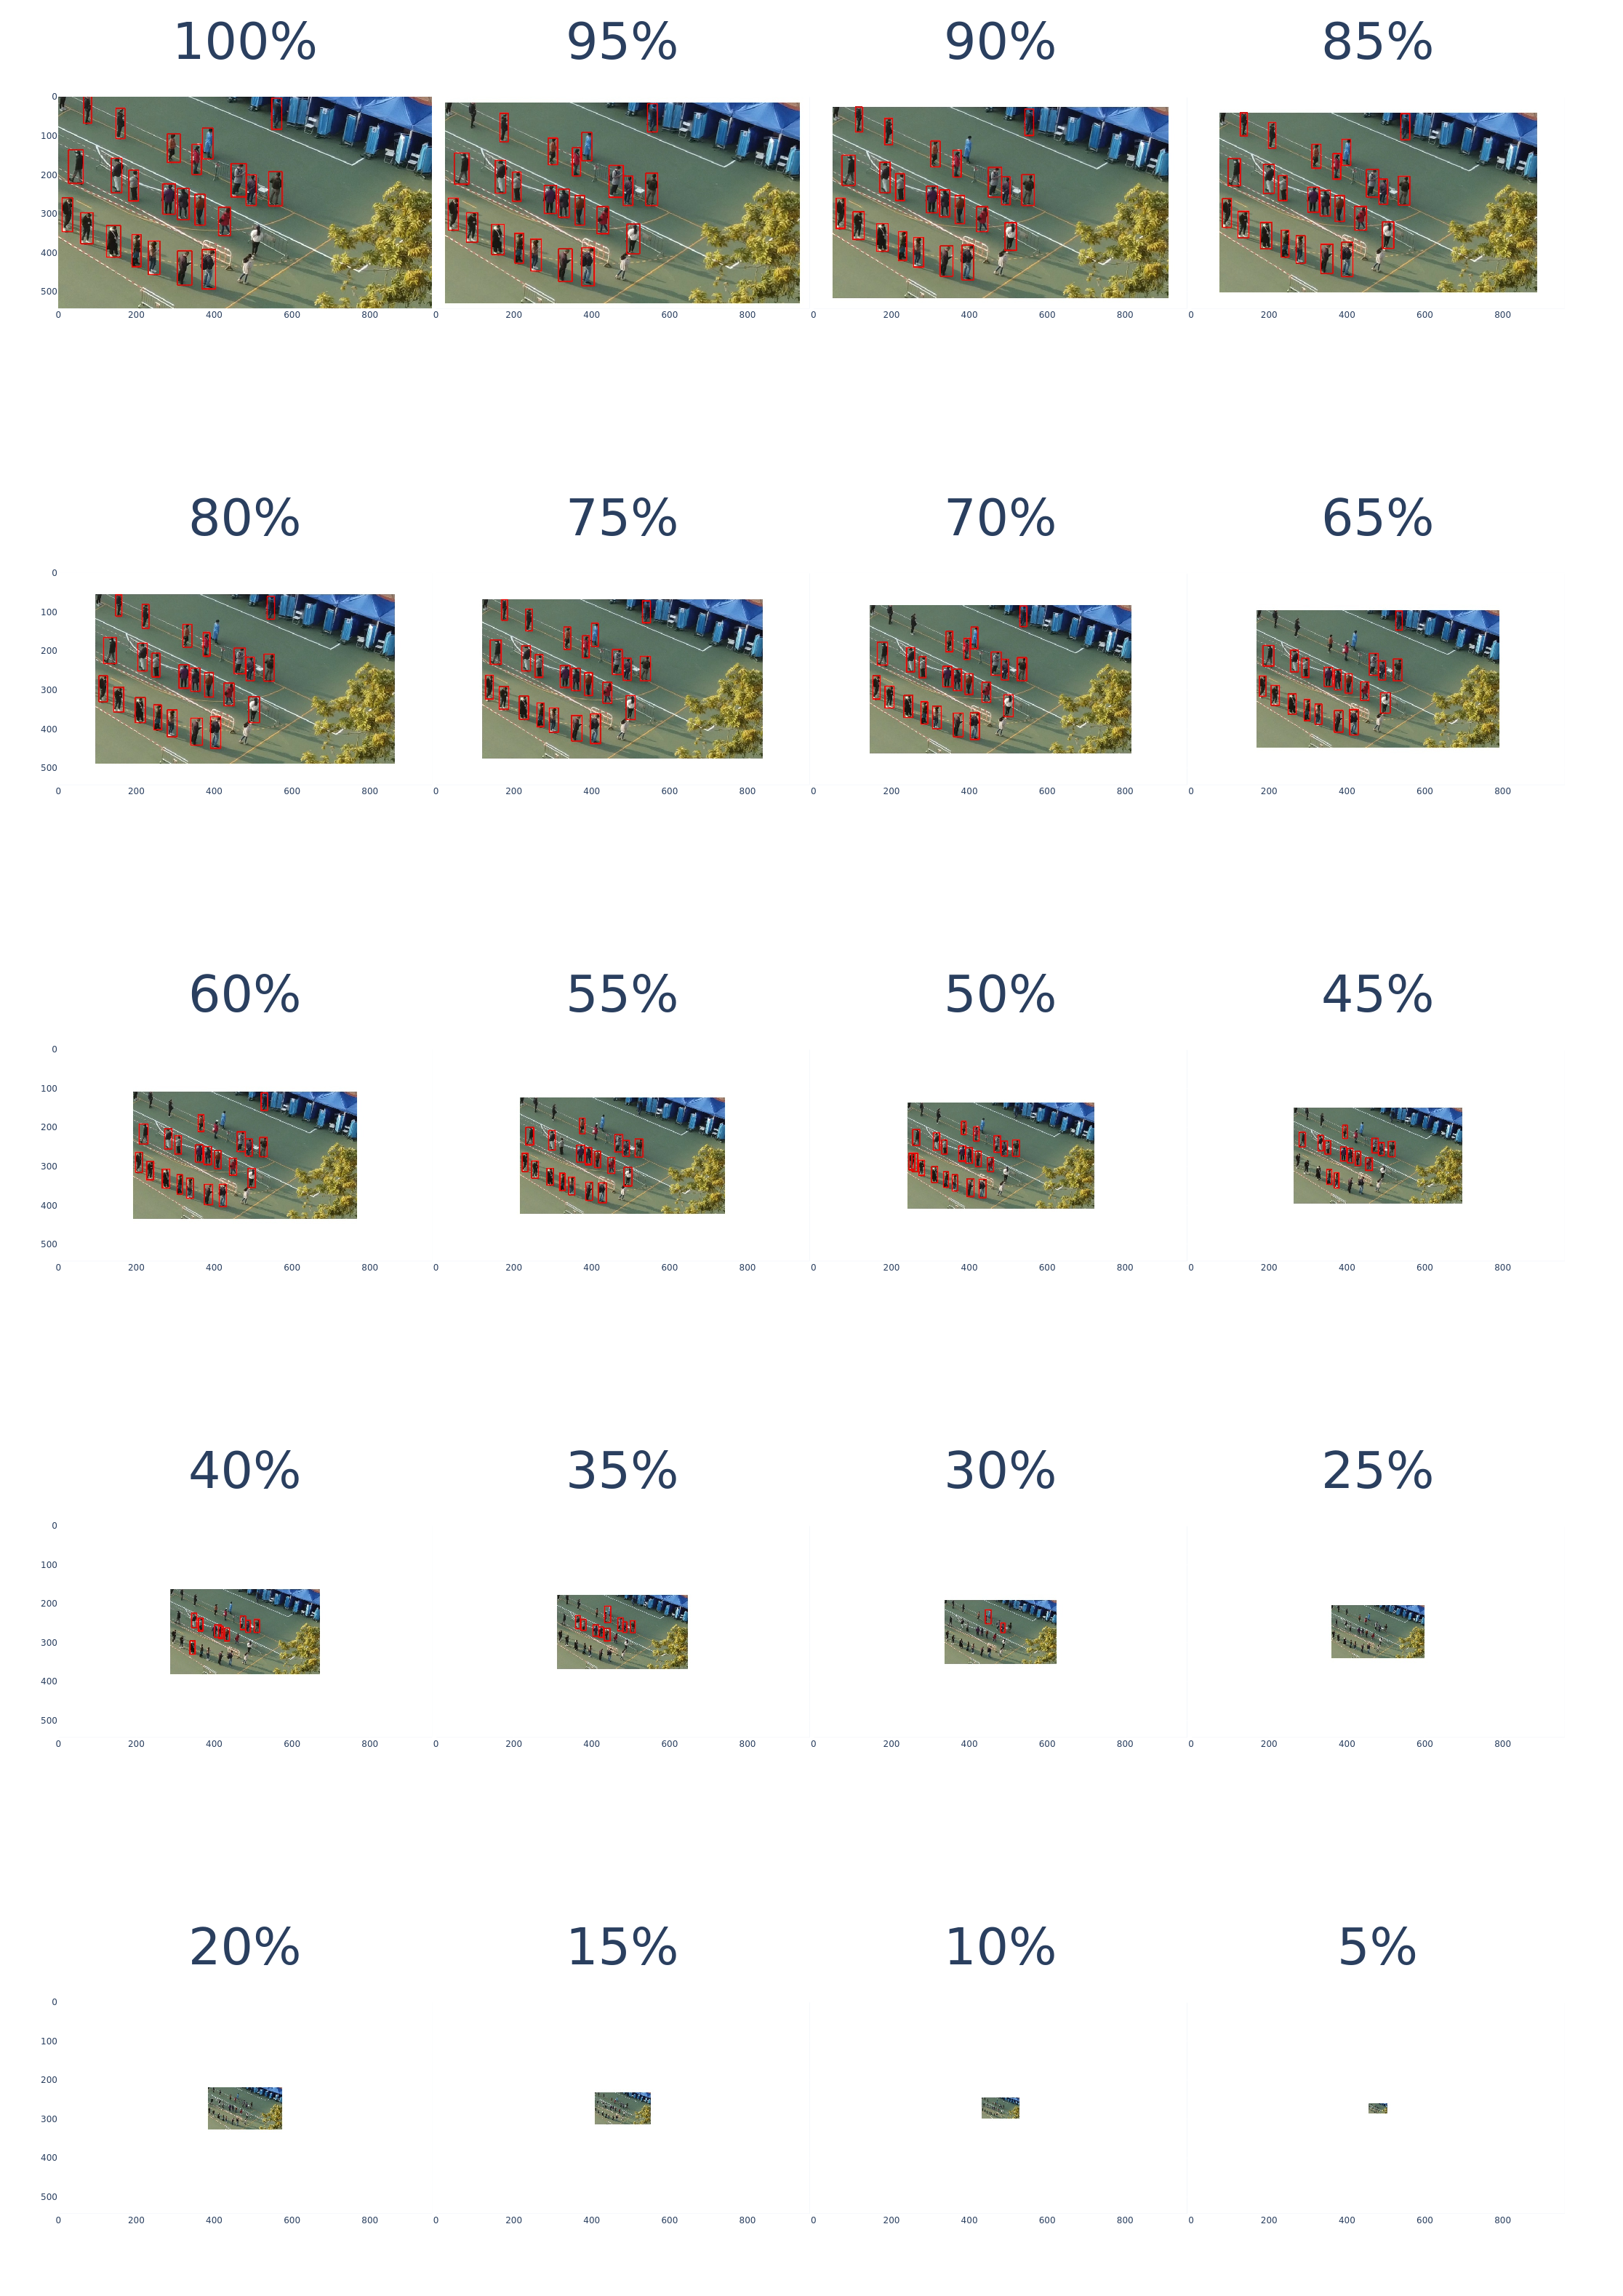

In [4]:
from plotly.subplots import make_subplots
import plotly.express as px
import math
import os
import cv2
peoplenet_height = 544
peoplenet_width = 960
step = 0.05
fig = make_subplots(rows=5, cols=4, shared_yaxes=True, horizontal_spacing=0.0025,
                   subplot_titles=("100%", "95%", "90%", "85%", "80%", "75%", "70%", "65%", "60%", "55%"
                                  , "50%", "45%", "40%", "35%", "30%", "25%", "20%", "15%", "10%", "5%"))

directory = 'inference_images'
files = os.listdir(directory)
files = [x for x in files if x[-4:]=='.jpg']
files.sort(key=lambda x:int(x.split('_')[1]), reverse=True)
i, j =1, 1 
for filename in files:
    path = os.path.join(directory, filename)
    if os.path.isfile(path):
        img = cv2.imread(path)
        fig.add_trace(px.imshow(img[...,::-1]).data[0], i, j)
        j+=1
        if j>4:
            i+=1
            j=1
fig.update_layout(width=2232, height=3157)
fig.update_annotations(font_size=70)
fig.show(renderer="png")

### Result Evaluation

In [15]:
import pandas as pd
df = pd.DataFrame({
    'height' : height_array,
    'width' : width_array,
    'Number of BBox' : count_array,
    'Pixel Count of Smallest BBOX' : smallest_rects_in_group,})
df = df.sort_values(by=['height'])

In [16]:
import seaborn as sns
df['Minification factor'] = round(df['height'] / 544,2)
first_column = df.pop('Minification factor')
df.insert(0, 'Minification factor', first_column)
df = df.drop(['height', 'width'], axis=1)
df.to_csv('out.csv', index=False)

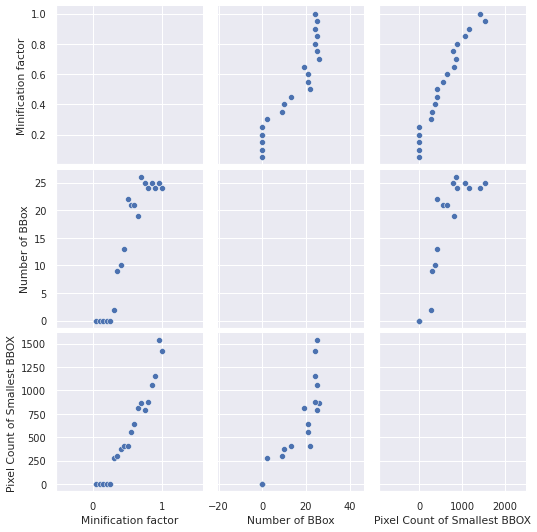

In [26]:
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(15,10)}, font_scale = 0.9)
pp = sns.pairplot(df,
             diag_kind="kde",
             diag_kws={"linewidth": 0, "shade": False})
fig = pp.fig
fig.savefig("out.png") 

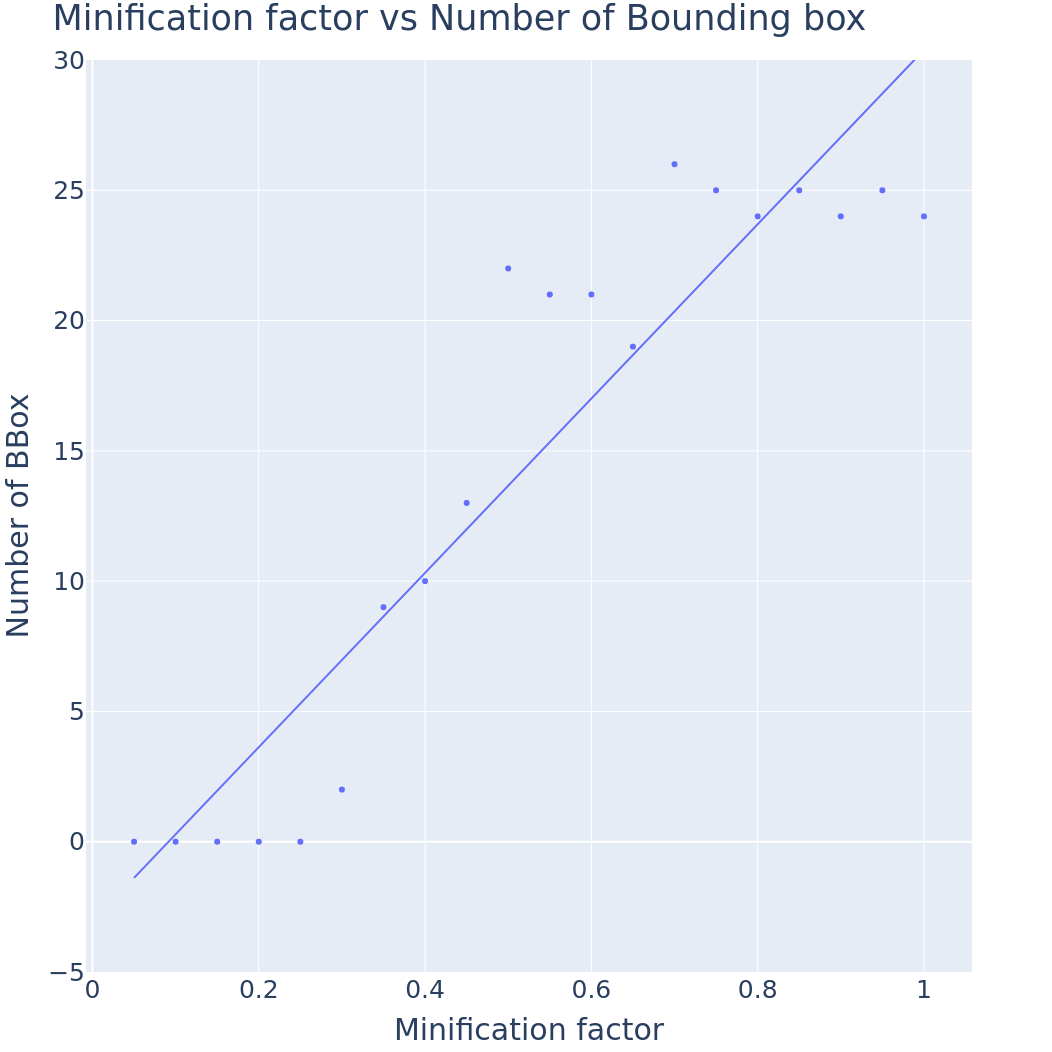

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     113.3
Date:                Sun, 03 Apr 2022   Prob (F-statistic):           3.40e-09
Time:                        13:10:25   Log-Likelihood:                -55.309
No. Observations:                  20   AIC:                             114.6
Df Residuals:                      18   BIC:                             116.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0579      1.882     -1.625      0.122      -7.012       0.897
x1            33.4436      3.143     10.642      0.000      26.841      40.046
==============================================================================
Omnibus:                        0.544   Durbin-Watson:                   0.598
Prob(Omnibus):                  0.762   Jarque-Bera (JB):                0.592
Skew:                           0.323   Prob(JB):                        0.744
Kurtosis:                       2.460   Cond. No.                         4.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
import plotly.express as px

fig = px.scatter(df, x="Minification factor", y="Number of BBox", trendline="ols")
fig.update_layout(yaxis_range=[-5,30])
fig.update_layout(title='Minification factor vs Number of Bounding box', font=dict(size=25))

fig.update_layout(width=1052, height=1052)

fig.show(renderer="png")

results = px.get_trendline_results(fig)
results.values[0][0].summary()

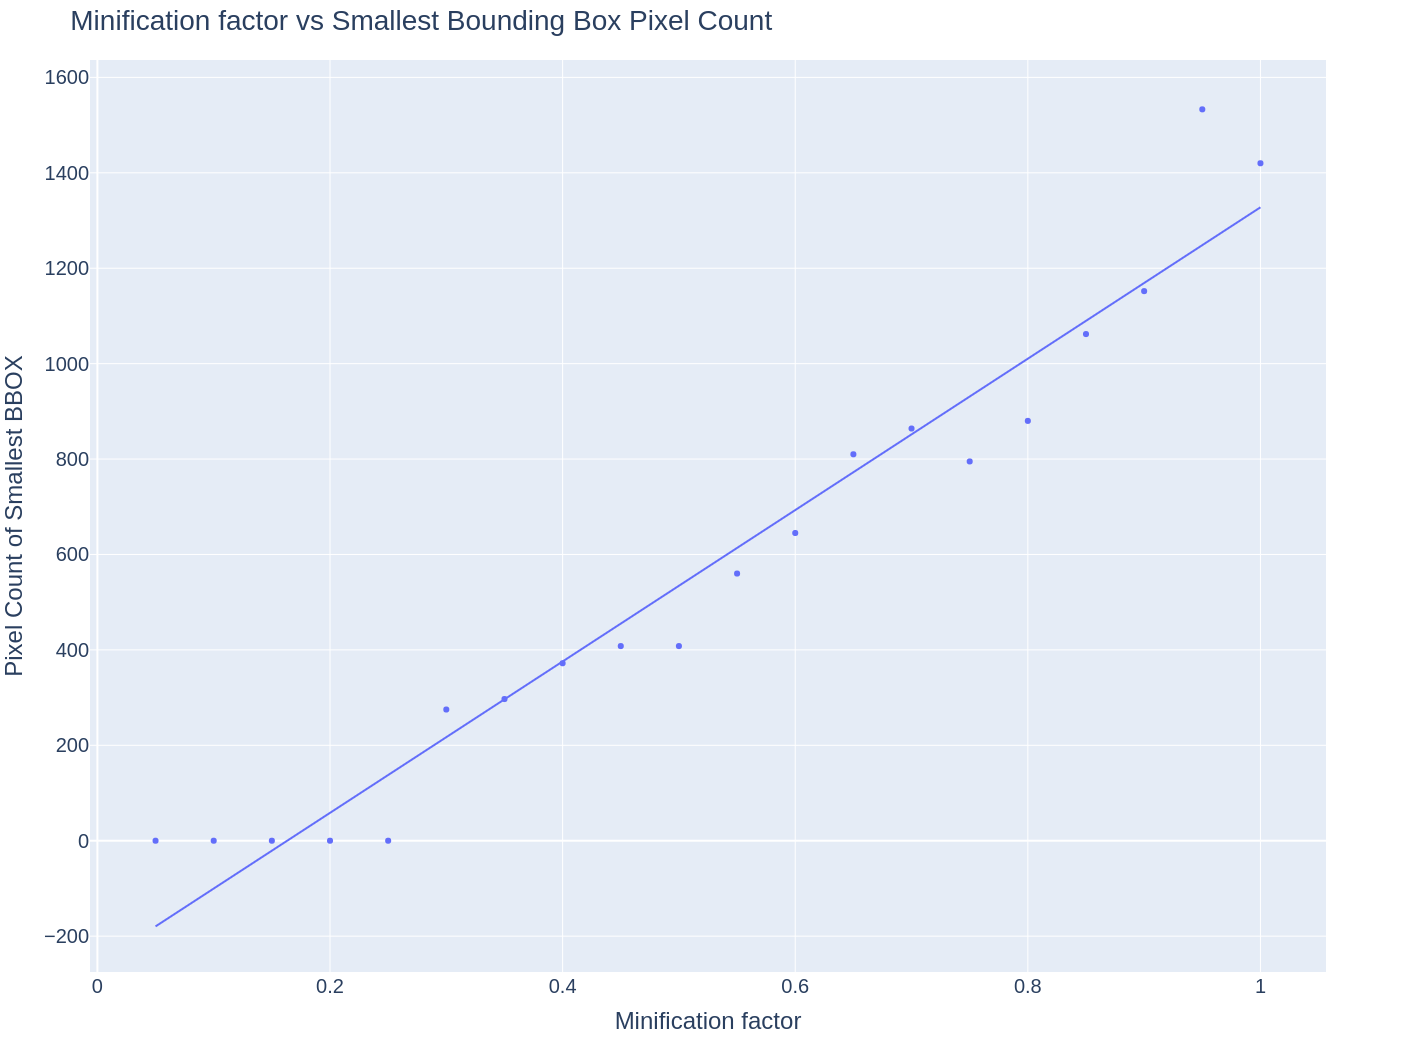

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     343.1
Date:                Sun, 03 Apr 2022   Prob (F-statistic):           3.60e-13
Time:                        13:04:58   Log-Likelihood:                -121.41
No. Observations:                  20   AIC:                             246.8
Df Residuals:                      18   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -258.9158     51.302     -5.047      0.000    -366.698    -151.133
x1          1586.6015     85.653     18.524      0.000    1406.651    1766.552
==============================================================================
Omnibus:                        5.490   Durbin-Watson:                   1.134
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                3.250
Skew:                           0.911   Prob(JB):                        0.197
Kurtosis:                       3.763   Cond. No.                         4.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
fig = px.scatter(df, x="Minification factor", y="Pixel Count of Smallest BBOX", trendline="ols")
fig.update_layout(title='Minification factor vs Smallest Bounding Box Pixel Count', font=dict(size=20))

fig.update_layout(width=1052, height=1052)

fig.show(renderer="png")

results = px.get_trendline_results(fig)
results.values[0][0].summary()

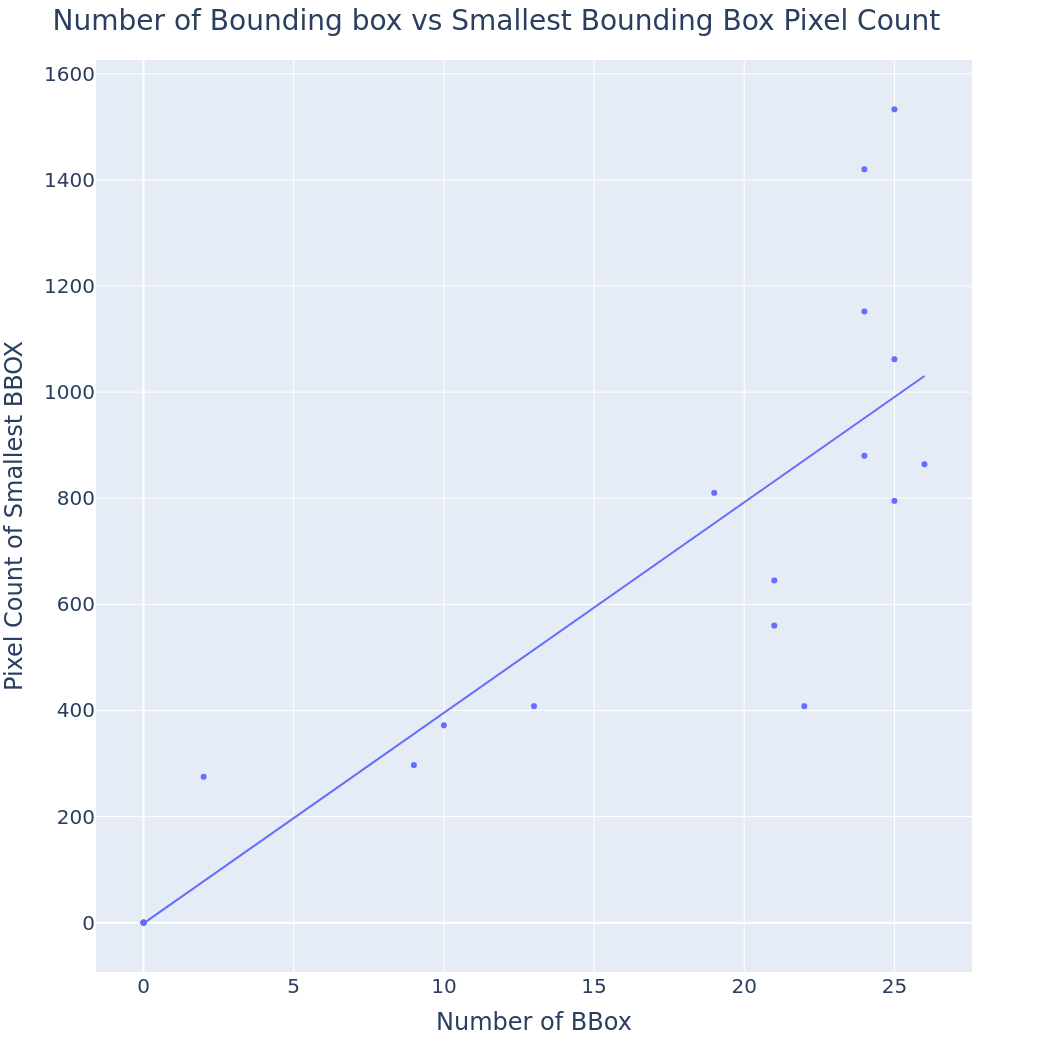

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     60.35
Date:                Sun, 03 Apr 2022   Prob (F-statistic):           3.71e-07
Time:                        13:10:10   Log-Likelihood:                -136.69
No. Observations:                  20   AIC:                             277.4
Df Residuals:                      18   BIC:                             279.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2770     91.080     -0.014      0.989    -192.628     190.074
x1            39.6777      5.107      7.769      0.000      28.947      50.408
==============================================================================
Omnibus:                        3.641   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.162   Jarque-Bera (JB):                1.743
Skew:                           0.610   Prob(JB):                        0.418
Kurtosis:                       3.777   Cond. No.                         30.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
fig = px.scatter(df, x="Number of BBox", y="Pixel Count of Smallest BBOX", trendline="ols")
fig.update_layout(title='Number of Bounding box vs Smallest Bounding Box Pixel Count', font=dict(size=20))

fig.update_layout(width=1052, height=1052)
fig.show(renderer="png")

results = px.get_trendline_results(fig)
results.values[0][0].summary()
